# GDP Forecast

---

The objective of this notebook is to perform Peruvian GDP forecast (nowcast), based in an ARMA model forecast and supported by the forecast of the top 10 Peruvian GDP predictors identified by <a href='#FPerez'>F. Pérez (2018).</a>

In [1]:
# Libraries
import warnings


import numpy as np
import pandas as pd
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt


from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import arma_order_select_ic


warnings.filterwarnings("ignore")

## Data

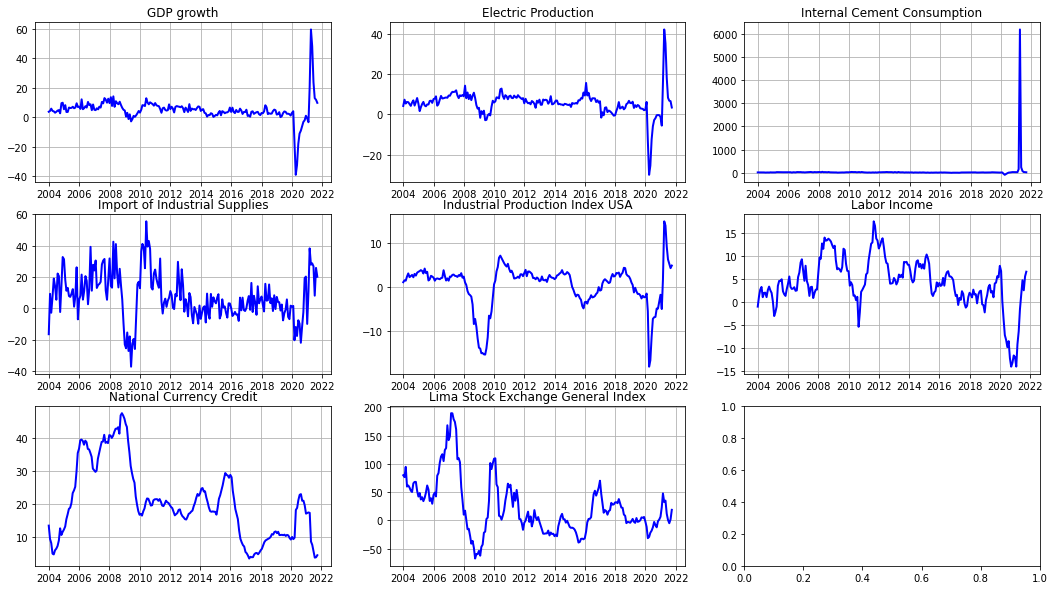

In [8]:
## Data
df = pd.read_csv(r".\data\GDPForecastData.csv")
df.set_index('DATE', inplace=True)
df.index = pd.to_datetime(df.index).date

## Graphical presentation
# Figure definition
fig, axs = plt.subplots(3, 3,figsize=(18, 10))

# Titles for variables
var_titles = ['GDP growth','Electric Production',
              'Internal Cement Consumption','Import of Industrial Supplies',
              'Industrial Production Index USA','Labor Income',
              'National Currency Credit', 'Lima Stock Exchange General Index']

# graphing loop
for var in range(len(df.columns)):
    if var <= 2:
        row_idx = 0
    elif var <= 5:
        row_idx = 1
    elif row_idx <= 8: 
        row_idx = 2
    else:
        print('Invalid # if variables')
        
    axs[row_idx,var-3*row_idx].plot(df[df.columns[var]],
                                    color='b',
                                    linewidth=2.0)
    
    axs[row_idx,var-3*row_idx].grid(which='major')
    
    axs[row_idx,var-3*row_idx].set_title(var_titles[var])

# Auxiliar Variables

In this part we set the auxiliar variables to get the ARMA forecast for the support variables, GDP ARMA forecast and datetime control. To set correctly these variables we need to look at the last observations of the dataset.

In [3]:
df.tail()

,PBI,PELEC,CINTC,VOLINPUT,INDPRO,INGRESO,CREDMN,IGBVL
2021-06-01,23.64,18.140523,66.240000,26.828222,9.2741,1.672393,7.683949,11.689240
2021-07-01,12.90,8.304085,22.380408,8.086567,6.3693,4.639684,5.843970,0.909292
2021-08-01,11.81,6.824366,15.420000,25.808699,5.3713,2.470084,3.801605,-4.970423
2021-09-01,9.71,6.616577,12.333361,20.163125,4.3775,5.468852,3.908349,1.840626
2021-10-01,NaN,3.454289,NaN,NaN,4.9656,6.502496,4.530612,18.690091


In [12]:
armax       = 4                                 # max AR order to test
mamax       = 2                                 # mas MA order to test
lag         = 1                                 # Lag of GDP publish, against other variables 
crit        = "bic"                             # selection criteria
ini_date    = df.index[0]                       # initial date
end_GDP     = df.index[-2]                      # GDP final obs date
end_date    = df.index[-1]                      # final date
num_hor     = 3                                 # forecast periods
ini_aux    = (end_date
              + relativedelta(months=+1))       # initial forecast date
end_aux    = (end_date
              + relativedelta(months=+num_hor)) # final forecast date
ini_forc    = (end_GDP
              + relativedelta(months=+1))       # initial forecast date
end_forc    = (end_GDP
              + relativedelta(months=+num_hor+lag)) # final forecast date

# Model Selection

In this part we get the model selection for every variable

In [13]:
lagresults = pd.DataFrame(columns=df.columns,index=range(0,1))

for c in df.columns:
    order_selection = arma_order_select_ic(df[ini_date:end_GDP][c],
                                           max_ar = armax,
                                           max_ma = mamax,
                                           ic = crit)
    # Getting results, depends on manual criteria change
    lagresults[c][0] = str(order_selection.bic_min_order) 

lagresults

,PBI,PELEC,CINTC,VOLINPUT,INDPRO,INGRESO,CREDMN,IGBVL
0,"(4, 2)","(3, 2)","(0, 0)","(3, 2)","(1, 1)","(2, 0)","(2, 1)","(2, 1)"


# Support variables forecast

In [24]:
#'Electric Production'
pelec_mod     = sm.tsa.statespace.SARIMAX(df[ini_date:end_date]["PELEC"],
                                          order=(3, 0, 2),
                                          trend='c')
pelec_results = pelec_mod.fit()
pelec_f_aux   = pelec_results.get_forecast(steps=num_hor)
pelec_f       = pd.concat([df[ini_date:end_date]["PELEC"],
                           pelec_f_aux.predicted_mean])

#'Internal Cement Consumption'
cintc_mod     = sm.tsa.statespace.SARIMAX(df[ini_date:end_GDP]["CINTC"],
                                          order=(0, 0, 0),
                                          trend='c')
cintc_results = cintc_mod.fit()
cintc_f_aux   = cintc_results.get_forecast(steps=num_hor+lag)
cintc_f       = pd.concat([df[ini_date:end_GDP]["CINTC"],
                           cintc_f_aux.predicted_mean])


#'Import of Industrial Supplies',

             # 'Industrial Production Index USA','Labor Income',
             # 'National Currency Credit', 'Lima Stock Exchange General Index'


# References
<a id='FPerez'>Pérez, Fernando, 2018.</a> "Nowcasting Peruvian GDP using Leading Indicators and Bayesian Variable Selection," Working Papers 2018-010, Banco Central de Reserva del Perú. [PDF Link](https://www.bcrp.gob.pe/docs/Publicaciones/Documentos-de-Trabajo/2018/documento-de-trabajo-010-2018.pdf) 
